In [1]:
import sys
!{sys.executable} -m pip install ipython-autotime
!{sys.executable} -m pip install pydot
!{sys.executable} -m pip install graphviz
%load_ext autotime

In [2]:
from os import listdir
from os.path import isfile, isdir, join, exists
import shutil
import ntpath
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict
from graphviz import Digraph
import statistics
from itertools import groupby
import math
import random

time: 708 ms


## Environment

In [3]:
class Stocks:
    def __init__(self, training_data, expected_return_step_size, round_num_digits, bank, transaction_cost):
        
        #data to generate transitions - sanitize and copy
        self.training_data = []
        for t in training_data:
            self.training_data.append(t[t.average > 0].copy())
        
        #amount of past data to calculate expected return
        self.expected_return_step_size = expected_return_step_size
        
        #while calculating expected return it is rounded to minimize number of states
        self.round_num_digits = round_num_digits
        
        #calculate return and expected return for each data row
        for t in self.training_data:
            self.calculate_return(t)
            self.calculate_expected_return(t)
        
        self.test_data = []
            
        #rewards by transitions key - mean os simple return
        self.mean_rewards = self.find_rewards(self.training_data)
        
        # transitions probabilities - (expected return)[(next expected return, probability),...]
        self.transitions = []
        self.transitions_keys = []
        for t in self.training_data:
            transit = self.find_transitions(t)
            self.transitions.append(transit)
            #sort keys to avoid mixing indexes
            transit_keys = list(transit.keys())
            transit_keys.sort()
            self.transitions_keys.append(transit_keys)
        
        #amount of money to be invested
        self.open_bank = bank
        self.current_bank = bank
        
        #amount to be charged from each interaction
        self.transaction_cost = transaction_cost
        
        #Actions are the amount to allocate in each asset
        #Last asset is cash
        #total sum must be 100 percent
        # 0 0 100
        action_range = 25
        self.actions = []
        for i in range(0, 100+action_range, action_range):
            for j in range(0, 100+action_range, action_range):
                for k in range(0, 100+action_range, action_range):
                    if i+j+k == 100:
                        self.actions.append((i, j, k))
        
        self.A = np.array(range(len(self.actions)))
        
        #States are expected return X portfolio allocation
        #it is built by [(x1,e1),(x2,e2)] where x is allocation and e expected return
        # chas is the last item and expected return is 0
        self.states = []
        for t in self.transitions_keys[0]:
            for t2 in self.transitions_keys[1]:
                for a in self.actions:
                     self.states.append(((a[0], t),(a[1], t2),(a[2], 0)))
        
        self.S = np.array(range(len(self.states)))
        
        # probabilities - (state,action)[(state_next, probability,reward),...]
        self.P = self.calculate_probabilities()
    
    #return is the percentage from current row average and last row average
    def calculate_return(self, data):
        row_return = []
        for i in range(len(data)):
            if i == 0:
                row_return.append(math.nan)
            else:
                curr = data.iloc[ i ]
                last = data.iloc[ i - 1 ]
                pct = (curr.average/last.average) - 1
                if math.isnan(pct) or pct == 0:
                    row_return.append(0)
                else:
                    row_return.append(pct)
        data['return'] = row_return 
    
    #expected return is the rounded mean from last expected_return_step_size last returns 
    def calculate_expected_return(self, data):
        expected_returns = []
        for i in range(len(data)):
            if i < self.expected_return_step_size:
                expected_returns.append(math.nan)
            else:
                expc = round(statistics.mean(data['return'][i-self.expected_return_step_size+1:i+1]), self.round_num_digits)
                if math.isnan(expc) or expc == 0:
                    expected_returns.append(0)
                else:
                    expected_returns.append(expc)
        data['expected_return'] = expected_returns
    
    #from the given data calculate expected return transitions  
    def find_transitions(self, training_data):
        weights = {}
        last_expected_return = training_data.iloc[len(training_data)-1].expected_return
        for key, group in groupby(sorted(training_data['expected_return'])):
            if math.isnan(key):
                continue
            next_steps = list(group)
            weight = 1/len(next_steps)
            if key == last_expected_return and len(next_steps) > 1:#fix weight for last expected return
                weight = 1/(len(next_steps)-1)
            weights['{}'.format(key)] = weight
        
        edges = []
        for i in range(len(training_data) - 1):
            cur = training_data.iloc[ i ]
            nxt = training_data.iloc[ i + 1 ]
            if math.isnan(cur.expected_return):
                continue
            edges.append(('{}'.format(cur.expected_return),'{}'.format(nxt.expected_return)))
        
        transitions_temp = {}
        for edge in edges:
            transitions_temp[edge[0]] = {}

        for edge in edges:
            transitions_temp[edge[0]][edge[1]] = 0

        for edge in edges:
            transitions_temp[edge[0]][edge[1]] += weights[edge[0]]
            
        transitions = {}
        for t in transitions_temp:
            transitions[t] = []
            for t_next in transitions_temp[t]:
                transitions[t].append((t_next, transitions_temp[t][t_next]))
        return transitions
    
    #find mean return for each expected return
    def find_rewards(self, training_data):
        all_rewards = []
        for train in training_data:
            rewards = {}
            for i in range(len(train)):
                item = train.iloc[ i ]
                if math.isnan(item.expected_return):
                    continue
                key = '{}'.format(item['expected_return'])
                rewards[key]=[]

            for i in range(len(train)):
                item = train.iloc[ i ]
                if math.isnan(item.expected_return):
                    continue
                key = '{}'.format(item['expected_return'])
                rewards[key].append(item['return'])

            mean_rewards = {}
            for k in rewards:
                mean_rewards[k] = np.mean(rewards[k])

            all_rewards.append(mean_rewards)

        return all_rewards
    
    #plot transitions
    def plot_transitions(self, save=False):
        
        for training_data in self.training_data:
        
            keys = []

            expected_return = list(training_data['expected_return'])
            for key, group in groupby(sorted(expected_return)):
                if math.isnan(key):
                    continue
                keys.append(key)
                print('{0} - {1}'.format(key, len(list(group))))

            print('\nstates {}'.format(len(keys)))

            edges = []
            for i in range(len(expected_return)-1):
                if math.isnan(expected_return[i]):
                    continue
                edges.append(('{}'.format(expected_return[i]),'{}'.format(expected_return[i+1])))

            # Create Digraph object
            dot = Digraph()
            dot.edges(edges)
            if save:
                dot.render('~Downloads/transitions.gv', view=True)  
            display(dot)

            display(env.transitions)
        
    # get state index and retrieve ammount invested and index on transition keys for each asset   
    def decompose_s(self, s):
        return self.states[s]
    
    # get percentage for each asset from a given action index
    def decompose_a(self, a):
        return self.actions[a]
    
    def compose_s(self, action, next_expec_index_1, next_expec_index_2):
        state = ((action[0], next_expec_index_1),(action[1], next_expec_index_2),(action[2], 0))
        for i in range(len(self.states)):
            if self.states[i] == state:
                return i
    
    # return possible transactions from a given s and action
    def calculate_probabilities(self):
        # probabilities - (state,action)[(state_next, probability,reward),...]
        P = {}
        
        total = len(self.S) * len(self.A)
        calculated = 0
        for s in self.S:
            for a in self.A:
                P[(s, a)] = []
                
                calculated+=1
                print('{}/{}'.format(calculated, total), end="\r", flush=False)
                
                state = self.states[s]
                action = self.actions[a]
                
                asset_1 = state[0]
                asset_2 = state[1]
                cash = state[2]
                
                next_returns_1 = self.transitions[0][asset_1[1]]
                next_returns_2 = self.transitions[1][asset_2[1]]
                
                for next_expec_1, prob_1 in next_returns_1:
                    if next_expec_1 in self.transitions_keys[0]:
                        next_expec_index_1 = self.transitions_keys[0].index(next_expec_1)
                        for next_expec_2, prob_2 in next_returns_2:
                            if next_expec_2 in self.transitions_keys[1]:
                                next_expec_index_2 = self.transitions_keys[1].index(next_expec_2)
                                
                                #build next state
                                next_state = self.compose_s(action, next_expec_1, next_expec_2)
                                #combine probabilities
                                prob = prob_1 * prob_2
                                #calculate reward
                                reward = self.calculate_reward(s,next_state) 
                                P[(s, a)].append((next_state,prob,reward))
        return P
                        
                
    def calculate_reward(self, last_state_index, next_state_index):
        # reward = (float(next_expec) - float(current_expec)) * next_invested
        last_state = self.states[last_state_index]
        next_state = self.states[next_state_index]
        
        if last_state == next_state:
            return 0
        
        dif_1 = next_state[0][0] - last_state[0][0]
        dif_2 = next_state[1][0] - last_state[1][0]
        dif_3 = next_state[2][0] - last_state[2][0]
        
        total_dif = 0
        if dif_1 > 0:
            total_dif += dif_1 
        if dif_2 > 0:
            total_dif += dif_2
        if dif_3 > 0:
            total_dif += dif_3
            
        
            
        gain_1 = (self.mean_rewards[0][last_state[0][1]] * self.open_bank)*(next_state[0][0]/100.0)
        gain_2 = (self.mean_rewards[1][last_state[1][1]] * self.open_bank)*(next_state[1][0]/100.0)
            
        discount = self.open_bank * (total_dif/100.0) * self.transaction_cost
        #if (gain_1 + gain_2 - discount) > 0 and discount > 0:
        #    print('g1{}, g2{}, dif{}, disc{}'.format(gain_1, gain_2, total_dif, discount))
        max_allow = 50
        if total_dif > max_allow:
            return -100
        
        if total_dif == max_allow:
            if dif_1 == 0 or dif_2 == 0 or dif_2 == 0:
                return -100
        
        return gain_1 + gain_2 - discount
    
    def execute(self, s, a):
        random_number = random.uniform(0, 1)
        return self.execute_with_prob(s,a,random_number)
            
    def execute_with_prob(self, s, a, random_number):
        #pct = self.decompose_a(a)
        #if pct > 0:
            #self.apported_count +=1
        
        t_sum = 0.0
        for s_next, t, r in self.P[(s, a)]:
            t_sum += t
            if random_number <= t_sum:
                self.history_states.append(self.states[s])
                return s_next, r
    
    def reset(self):
        self.current_bank = self.open_bank
        self.real_data_index = self.expected_return_step_size - 1
        self.history_states = []
        
    @classmethod
    def create_env(cls, training_data, expected_return_step_size, round_num_digits, transaction_cost=0.002, bank = 100):
        return cls(training_data, expected_return_step_size, round_num_digits, bank, transaction_cost)

time: 21.7 ms


## Value Iteration

In [4]:
# Default Value Iteration method
class ValueIteration:

    @staticmethod
    def run(env, gamma=1, epsilon=1e-8, quiet=False):
        V = np.zeros(len(env.S))
        policy = np.zeros(len(env.S))
        steps = 0
        updates = 0
        while True:
            steps += 1
            prev_V = np.copy(V)
            for s in env.S:
                q, q_updates = ValueIteration.action_value(env, V, s, gamma)
                V[s] = max(q)
                policy[s] = np.argmax(q)
                updates += q_updates

            delta = np.max(np.fabs(prev_V - V))
            if not quiet:
                print('{} {}'.format(steps, delta), end="\r", flush=False)
            if delta < epsilon:
                break
        return policy, V, steps, updates

    @staticmethod
    def action_value(env, V, s, gamma=1):
        q = np.zeros(len(env.A))
        q_updates = 0
        for a in env.A:
            for s_next, t, r in env.P[(s, a)]:
                q_updates += 1
                q[a] += t * (r + gamma * V[s_next])

        return q, q_updates

time: 3.01 ms


# Value itaration with exponencial lambda

In [5]:
# Value itaration with exponencial lambda
class ValueIterationExp:
    @staticmethod
    def utility_function(x, lamb):
        return -1 * np.sign(lamb) * np.exp(-lamb * x)


    @staticmethod
    def run(env, lamb, gamma, epsilon=1e-8, quiet=False):
        V = np.zeros(len(env.S))
        policy = np.zeros(len(env.S))
        steps = 0
        updates = 0
        while True:
            steps += 1
            
            prev_V = np.copy(V)
            for s in env.S:
                q, q_updates = ValueIterationExp.action_value_rs(env, V, s, lamb, gamma)

                V[s] = (np.log(-1 * np.sign(lamb) * max(q)) / -lamb)

                policy[s] = np.argmax(q)
                updates += q_updates

            delta = np.max(np.fabs(prev_V - V))
            if not quiet:
                print('{} {}'.format(steps, delta), end="\r", flush=False)
            if delta < epsilon:
                break
        return policy, V, steps, updates

    @staticmethod
    def action_value_rs(env, V, s, lamb, gamma):
        q = np.zeros(len(env.A))
        q_updates = 0
        for a in env.A:
            for s_next, t, r in env.P[(s, a)]:
                q_updates += 1

                q[a] += t * ValueIterationExp.utility_function(r + gamma * V[s_next], lamb)

        return q, q_updates

time: 4.21 ms


# TESTS

## Plot Results

In [6]:
def calc_cvar(scores, pct):
    scores.sort()
    return np.mean(scores[:int(len(scores)*pct*0.01)])

def plot_cvar(results, label,title='Average rewards'):
    for key in results.keys():
        score_result = results[key]
        cvar_values = []
        for cvar_key in range(1,100):
            cvar_values.append(calc_cvar(score_result, cvar_key))
        plt.plot(cvar_values, label=label.format(key))

    plt.xlabel('Percentage of worst cases')
    plt.ylabel(title)
    plt.legend();
    plt.show()
    
def calc_cvar_greater(scores, pct):
    scores.sort(reverse=True)
    return np.mean(scores[:int(len(scores)*pct*0.01)])

def plot_cvar_greater(results, label, title='Average rewards'):
    for key in results.keys():
        score_result = results[key]
        cvar_values = []
        for cvar_key in range(100,1,-1):
            cvar_values.append(calc_cvar_greater(score_result, cvar_key))
        plt.plot(cvar_values, label=label.format(key))

    plt.xlabel('Percentage of best cases')
    plt.ylabel(title)
    plt.xticks(range(1,120,20), [100,80,60,40,20,0])
    plt.legend();
    plt.show()

def plot_test_results(keys, result, history, label, accumaled_in_period=None, graph_title=None, multiple_run=True):
    #PLOTING RESULTS
    if multiple_run:
        for k in result.keys():
            plt.plot(sorted(result[k]), label=label.format(k))
        plt.ylabel('sorted rewards')
        if graph_title is not None:
            plt.title(graph_title)
        plt.legend();
        plt.show()

        #PLOTING RESULTS
        for k in result.keys():
            plt.plot(result[k], label=label.format(k))
        plt.ylabel('rewards')
        if graph_title is not None:
            plt.title(graph_title)
        plt.legend();
        plt.show()
        
    # Comparing with accumulated in the period
    recompensa_acc = []
    recompensa_ks = []
    bar_colors = []
    if accumaled_in_period is not None:
        recompensa_ks.append('AAPL')
        recompensa_ks.append('AMZN')
        recompensa_ks.append('AAPL/AMZN')
        aapl = sum(accumaled_in_period[0])
        amzn = sum(accumaled_in_period[1])
        recompensa_acc.append(aapl)
        recompensa_acc.append(amzn)
        recompensa_acc.append((aapl+amzn)/2)
        if aapl < 0:
            bar_colors.append('red')
        else:
            bar_colors.append('green')
            
        if amzn < 0:
            bar_colors.append('red')
        else:
            bar_colors.append('green')
            
        if (aapl+amzn)/2 < 0:
            bar_colors.append('red')
        else:
            bar_colors.append('green')
    for k in keys:
        recompensa_acc.append(sum(result[k]))
        recompensa_ks.append(label.format(k))
        if sum(result[k]) < 0:
            bar_colors.append('red')
        else:
            bar_colors.append('green')

    plt.bar(np.arange(len(recompensa_ks)),recompensa_acc,color=bar_colors)
    plt.ylabel('Accumulated rewards')
    if accumaled_in_period is not None:
        plt.xticks(np.arange(len(recompensa_ks)),recompensa_ks, rotation='vertical')
    else:
        plt.xticks(np.arange(len(recompensa_ks)),recompensa_ks, rotation='vertical')
    if graph_title is not None:
        plt.title(graph_title)
    #plt.legend();
    plt.show()
    
    if multiple_run:
        plot_cvar(result, label)
        plot_cvar_greater(result, label)
    
    invested_ks = []
    
    for k in history.keys():
        invested_asset_aapl = []
        invested_asset_amzn = []
        invested_asset_cash = []
        for h_arr in history[k]:
            for h in h_arr:
                invested_asset_aapl.append(h[0][0])
                invested_asset_amzn.append(h[1][0])
                invested_asset_cash.append(h[2][0])

        plt.bar(np.arange(3),[np.mean(invested_asset_cash), np.mean(invested_asset_aapl), np.mean(invested_asset_amzn)],color=['green', 'blue', 'blue'])
        plt.xticks(np.arange(3),['CASH', 'AAPL', 'AMZN'])
        plt.ylabel('Average invested')
        plt.title(label.format(k))

        plt.show()

time: 8.51 ms


## Helper to test policies with model created

In [7]:
def test_with_model(env, keys, policies, label, graph_title=None):
    #init accumulators
    result = {}
    history_exec = {}
    apported_count = {}
    for k in keys:
        history_exec[k] = []
        result[k] = []

    time_frame = 60
    n_episodes = 5000

    for e in range(n_episodes):
        #execute same scneario to all policies
        rand_probs = []
        for i in range(time_frame):
            rand_probs.append(random.uniform(0, 1))

        for k in keys:
            s0 = 0

            policy = policies[k]

            total_reward = 0
            rewards = []
            s = s0
            env.reset()
            for t in range(time_frame):
                a = policy[s]
                s_next, r = env.execute_with_prob(s,a,rand_probs[t])
                total_reward += r
                s = s_next

            result[k].append(total_reward)
            history_exec[k].append(env.history_states)
            
    plot_test_results(keys, result, history_exec, label,None,graph_title)

time: 2.62 ms


# load data

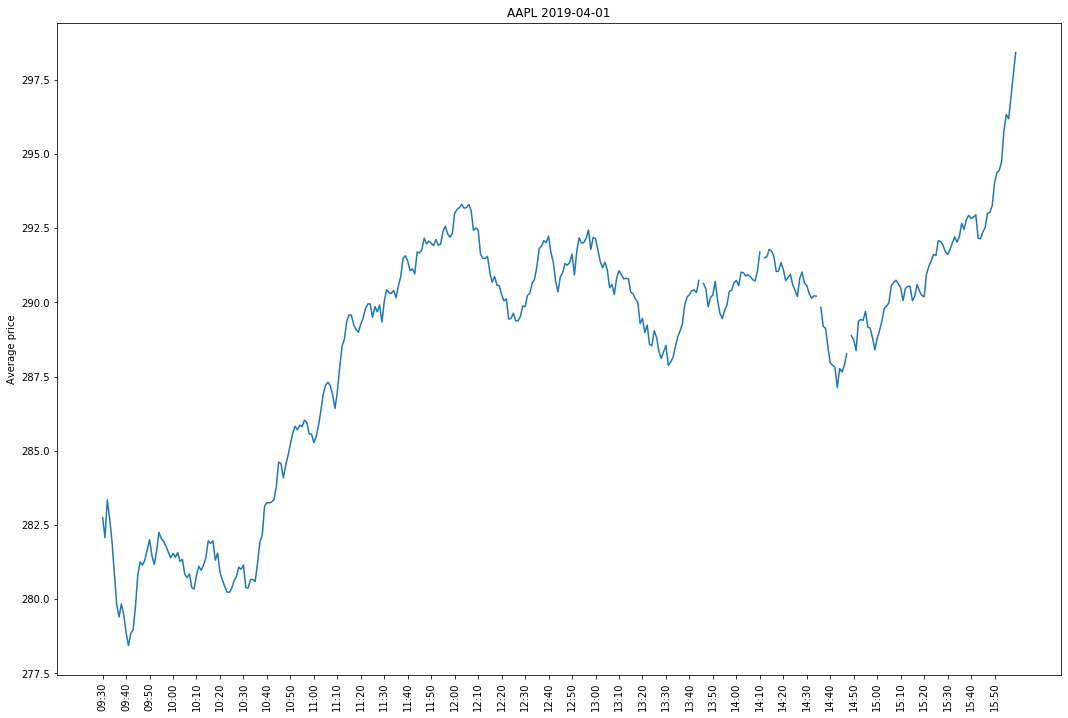

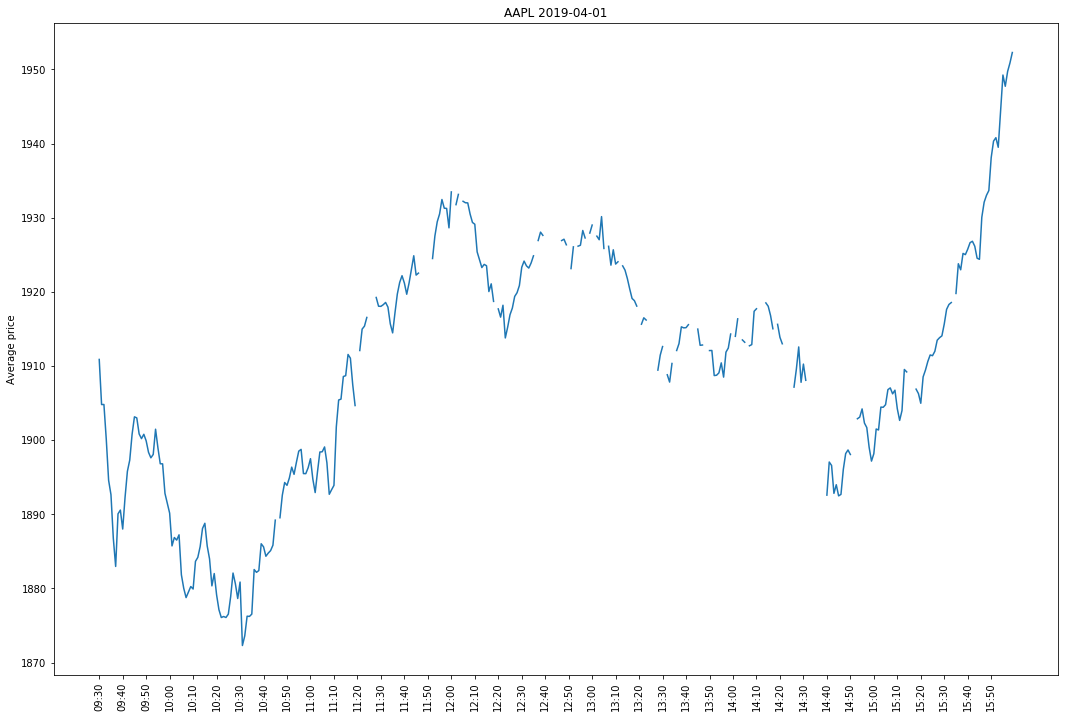

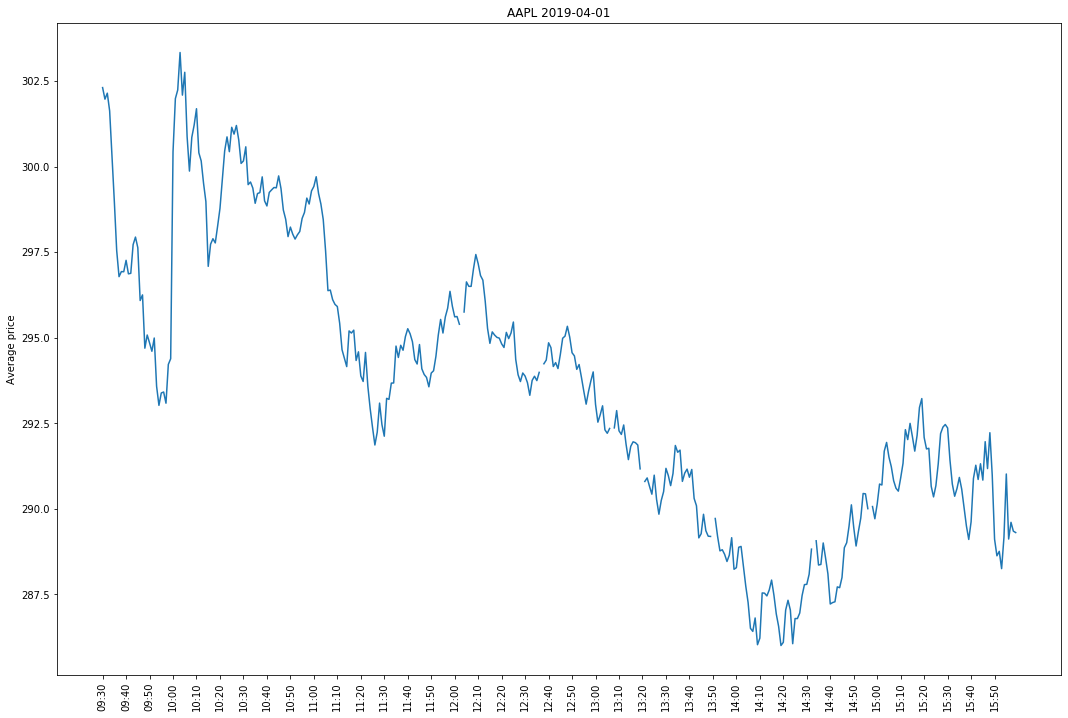

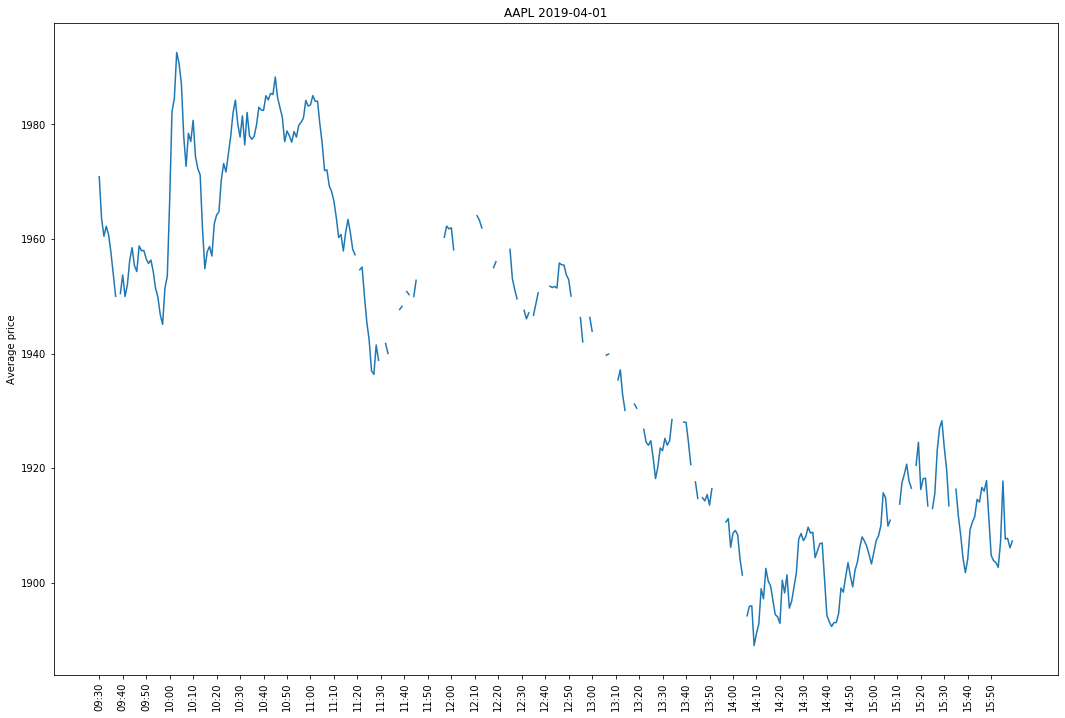

time: 1.38 s


In [8]:
def plot_avg(training_data, title):
    labels = []
    for i in np.arange(0, len(training_data), 10):
        labels.append(training_data['minute'][i])

    fig, ax1 = plt.subplots(1, 1, figsize=(18, 12))
    plt.plot(training_data['average'])
    plt.xticks(np.arange(0, len(training_data), 10), labels, rotation='vertical')
    #plt.xlabel('Minute')
    plt.title('AAPL 2019-04-01')
    plt.ylabel('Average price')
    plt.show()

data_aapl_win = pd.read_csv('./IEX_data/20200302_AAPL.csv')
data_amzn_win = pd.read_csv('./IEX_data/20200302_AMZN.csv')
data_aapl_loss = pd.read_csv('./IEX_data/20200303_AAPL.csv')
data_amzn_loss = pd.read_csv('./IEX_data/20200303_AMZN.csv')
    
plot_avg(data_aapl_win, title='AAPL - 20200302')
plot_avg(data_amzn_win, title='AMZN - 20200302')
plot_avg(data_aapl_loss, title='AAPL - 20200303')
plot_avg(data_amzn_loss, title='AMZN - 20200303')

# Run Value Iteration Exponential

In [9]:
from IPython.display import display, HTML

def run_test(data_1,data_2):
    training_data = [data_1,data_2]
    
    # training data
    step_size = 5
    num_digits = 3
    transaction_cost = 0.005
    env = Stocks.create_env(training_data, step_size, num_digits, transaction_cost)
    
    print('actions {} - states {}'.format(len(env.S),len(env.A)))
    
    lambs = [-3, 0.5, 2]
    lambs = [-5,0.5, 5]
    policies_lambda = {}
    for lamb in lambs:
        print('\nLAMB {}'.format(lamb))
        env.reset()

        policy, V, steps, updates = ValueIterationExp.run(env, lamb, 0.99, 1e-3)
        policies_lambda[lamb] = policy
        print('')
    
    display(HTML('<h1>Testing on Model</h1><br/>'))
    test_with_model(env, lambs, policies_lambda, 'lambda {}')


time: 2.03 ms


# AAPL win x AMZN win

actions 450 - states 15

LAMB -5
264 0.0009993993686170377

LAMB 0.5
157 0.0009945296692563943

LAMB 5
39 0.0009880839070758457


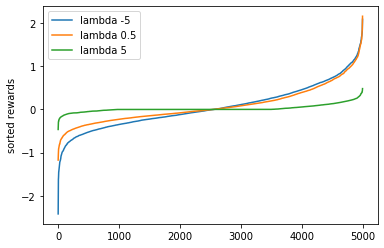

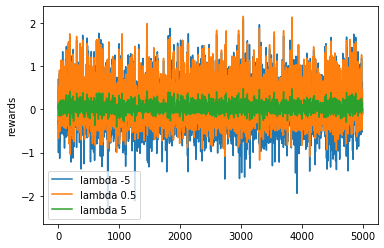

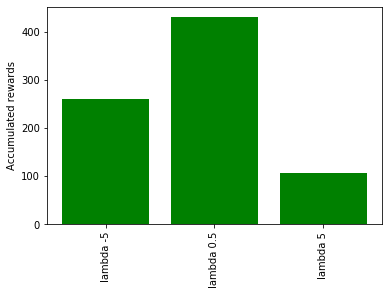

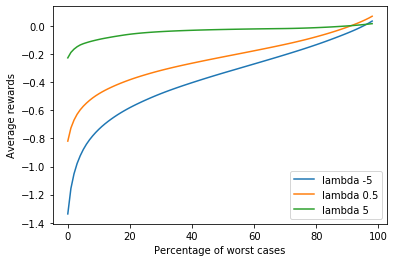

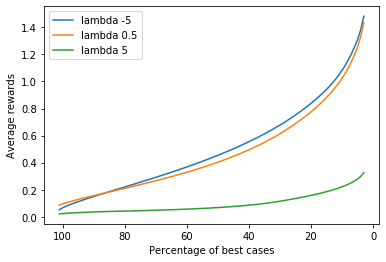

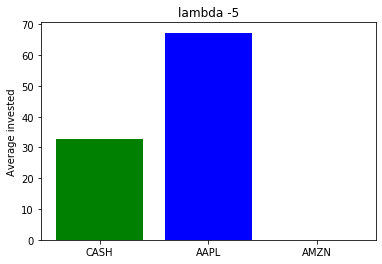

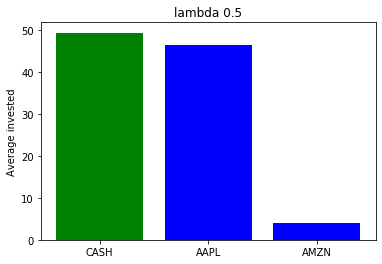

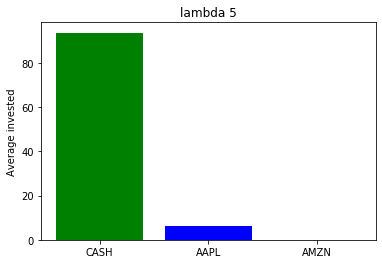

time: 2min 27s


In [10]:
run_test(data_aapl_win,data_amzn_win)

# AAPL loss x AMZN win

actions 675 - states 15

LAMB -5
342 0.0009892515569234206

LAMB 0.5
162 0.0009891945296670599

LAMB 5
34 0.0009949039462059661


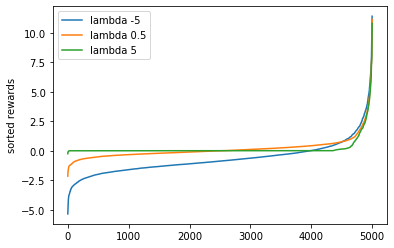

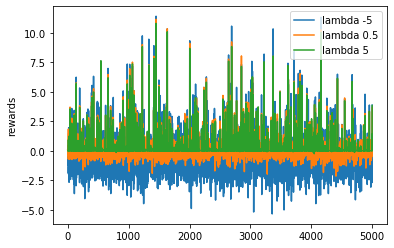

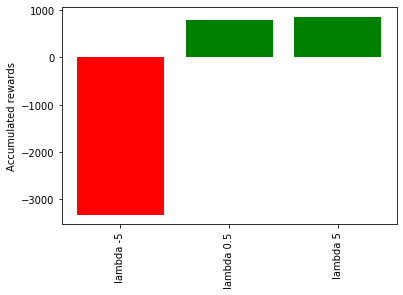

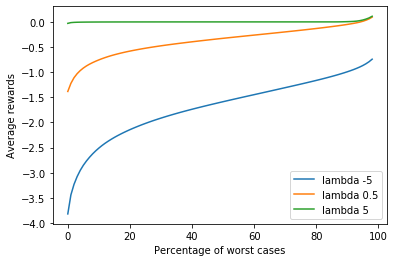

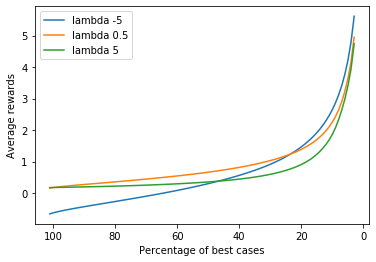

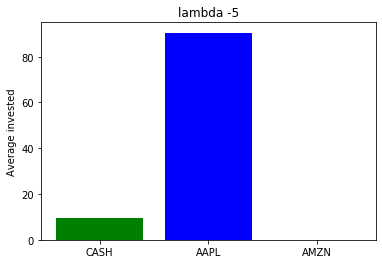

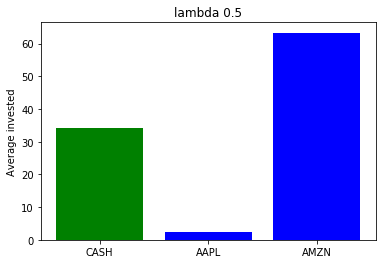

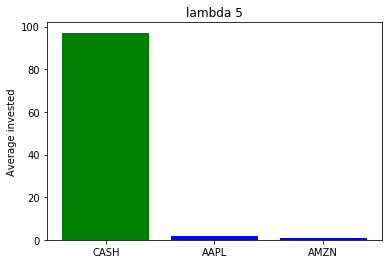

time: 5min 36s


In [11]:
run_test(data_aapl_loss,data_amzn_win)

# AAPL win x AMZN loss

actions 630 - states 15

LAMB -5
307 0.0009929684892142632

LAMB 0.5
166 0.0009895426594272172

LAMB 5
39 0.0009013316385538261


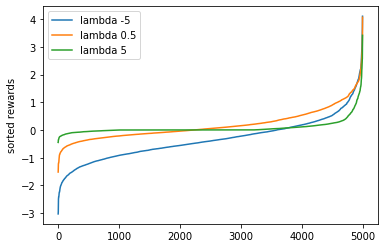

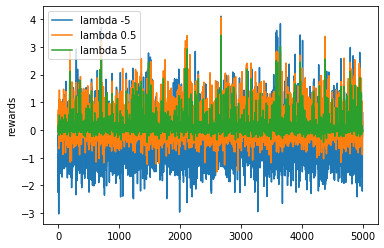

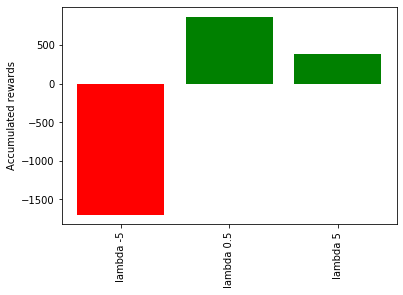

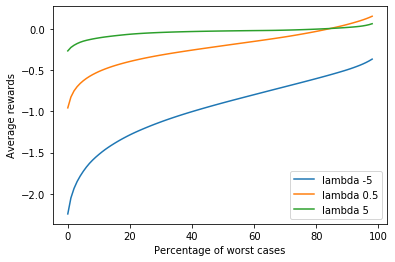

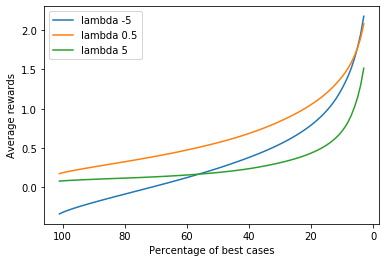

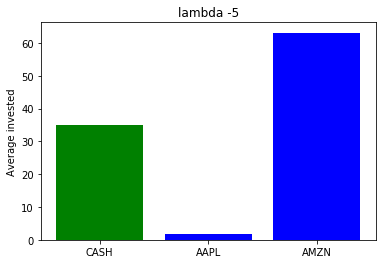

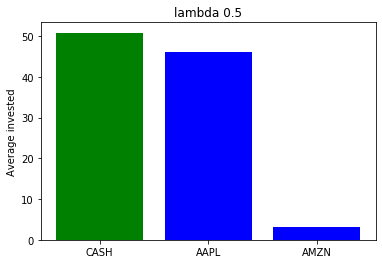

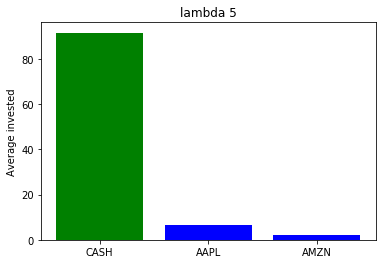

time: 4min 3s


In [12]:
run_test(data_aapl_win,data_amzn_loss)

# AAPL loss x AMZN loss

actions 945 - states 15

LAMB -5
341 0.0009937881371016033

LAMB 0.5
93 0.0009923359137194165

LAMB 5
32 0.0008960790390517004


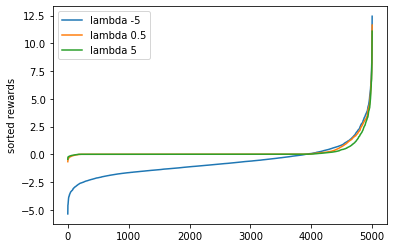

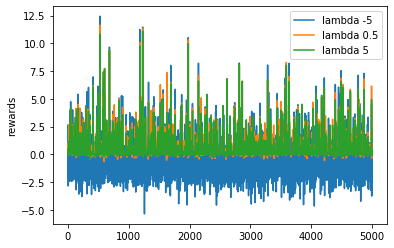

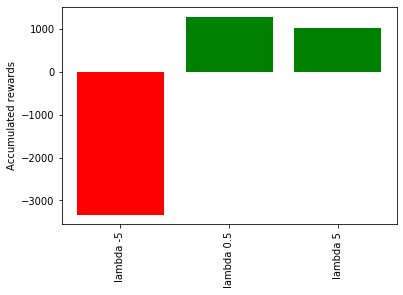

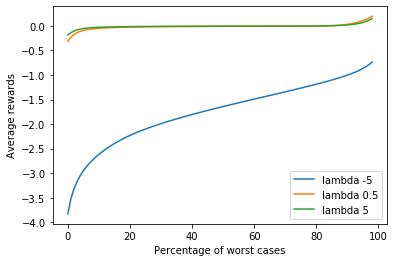

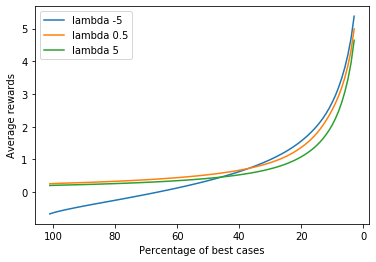

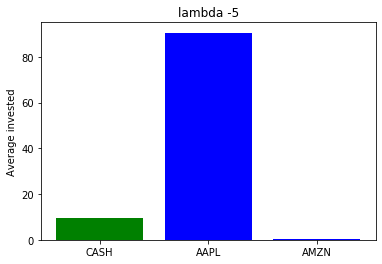

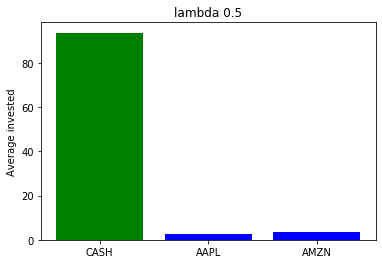

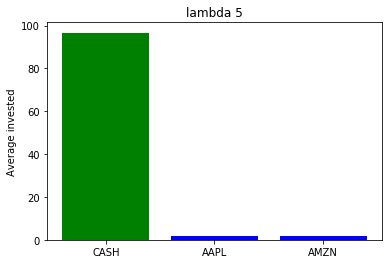

time: 7min 17s


In [13]:
run_test(data_aapl_loss,data_amzn_loss)